<a href="https://colab.research.google.com/github/keerthi5083/Diabetic-Retinopathy-using-CNN/blob/main/Diabetic_Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Set the base directory
base_dir = '/content/drive/MyDrive/Diabetic Retinopathy/gaussian_filtered_images'

# Create an empty list to hold image paths and their corresponding labels.
data = []

# Loop over each class subdirectory
for class_label in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_label)
    if os.path.isdir(class_dir):  # Check if it's a directory
        # Debugging: Print the directory being processed
        print(f"Processing directory: {class_label}")

        # Loop over each image in the class directory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)

            # Append image path and class label (as a string) to the data list
            data.append([image_path, class_label])

        # Debugging: Print number of images found in each directory
        print(f"Found {len(os.listdir(class_dir))} images in {class_label} directory.")

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Display the first few rows of the DataFrame
print(df.head())

# Display the count of each label in the DataFrame
print("Label distribution in DataFrame:")
print(df['label'].value_counts())

# Display a few sample rows for each label
for label in sorted(df['label'].unique()):
    print(f"\nSample images for label '{label}':")
    print(df[df['label'] == label].head())

Processing directory: Mild
Found 370 images in Mild directory.
Processing directory: No_DR
Found 1805 images in No_DR directory.
Processing directory: Moderate
Found 999 images in Moderate directory.
Processing directory: Severe
Found 193 images in Severe directory.
Processing directory: Proliferate_DR
Found 295 images in Proliferate_DR directory.
                                          image_path label
0  /content/drive/MyDrive/Diabetic Retinopathy/ga...  Mild
1  /content/drive/MyDrive/Diabetic Retinopathy/ga...  Mild
2  /content/drive/MyDrive/Diabetic Retinopathy/ga...  Mild
3  /content/drive/MyDrive/Diabetic Retinopathy/ga...  Mild
4  /content/drive/MyDrive/Diabetic Retinopathy/ga...  Mild
Label distribution in DataFrame:
label
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

Sample images for label 'Mild':
                                          image_path label
0  /content/drive/MyDriv

In [ ]:
# Define the split ratio
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Display the number of samples in each set
print("Distribution of the training set")
print(train_df['label'].value_counts())
print("\nDistribution of the validation set:")
print(val_df['label'].value_counts())


Distribution of the training set
label
No_DR             1444
Moderate           799
Mild               296
Proliferate_DR     236
Severe             154
Name: count, dtype: int64

Distribution of the validation set:
label
No_DR             361
Moderate          200
Mild               74
Proliferate_DR     59
Severe             39
Name: count, dtype: int64


In [ ]:
# Creating the ImageDataGenerator with data augmentation and rescaling
dataDR = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# Converting integer labels to strings in both train_df and val_df
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Create training data generator from train_df
train_data = dataDR.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Create validation data generator from val_df
valid_data = dataDR.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


Sample images from the training dataset:


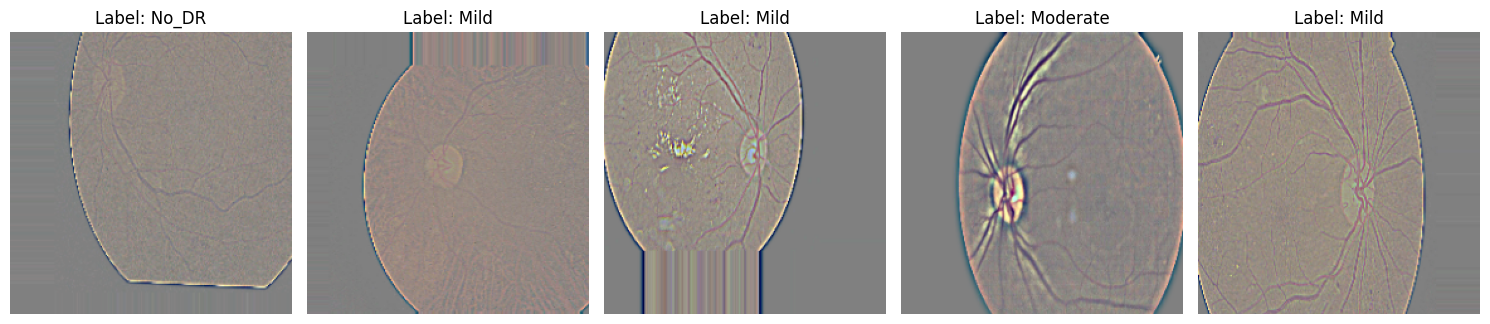

Sample images from validation dataset:


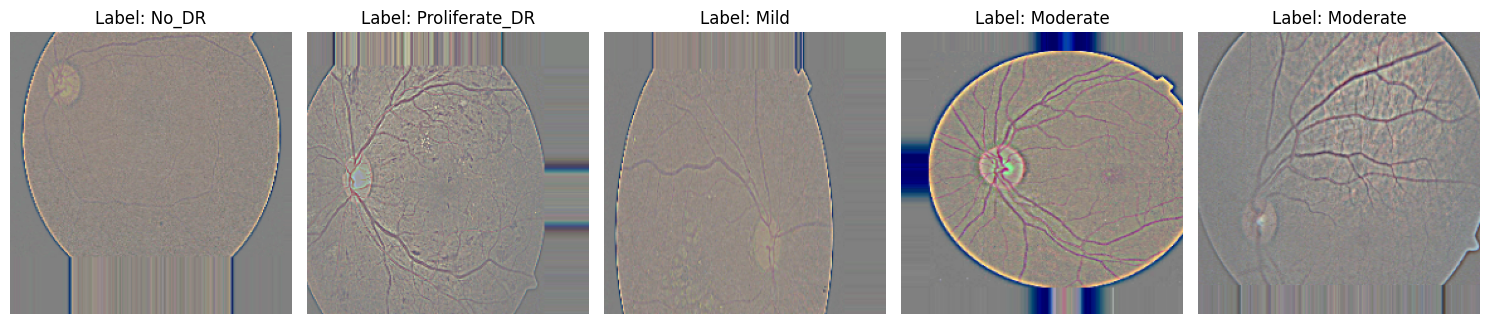

In [ ]:
#Define a mapping of labels from integers to strings
label_mapping = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

def display_sample_images(data_generator, num_samples=5):

    images, labels = next(data_generator)

    # Plot the first num_samples images with their labels
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        # Convert one-hot encoded label to integer, then to string
        int_label = labels[i].argmax()
        string_label = label_mapping.get(int_label, "Unknown")
        plt.title(f"Label: {string_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images from the training data
print("Sample images from the training dataset:")
display_sample_images(train_data, num_samples=5)

# Display sample images from the validation data
print("Sample images from validation dataset:")
display_sample_images(valid_data, num_samples=5)


In [ ]:
!pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [ ]:
# EfficientNet-B4 Model
import efficientnet.tfkeras as efn
model = tf.keras.Sequential([
        efn.EfficientNetB4(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])

model.compile(
    optimizer= "Adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

71892840/71892840 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history=model.fit(train_data,validation_data = valid_data,callbacks=[lr_callback],epochs=20,verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 1627s 15s/step - accuracy: 0.6226 - loss: 1.1175 - val_accuracy: 0.5894 - val_loss: 1.0943 - learning_rate: 1.0000e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 717ms/step - accuracy: 0.7162 - loss: 0.7846 - val_accuracy: 0.6985 - val_loss: 0.8292 - learning_rate: 1.0000e-04
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 717ms/step - accuracy: 0.7579 - loss: 0.6868 - val_accuracy: 0.7381 - val_loss: 0.7337 - learning_rate: 1.0000e-04
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 720ms/step - accuracy: 0.7882 - loss: 0.5894 - val_accuracy: 0.7476 - val_loss: 0.7258 - learning_rate: 1.0000e-04
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 716ms/step - accuracy: 0.7920 - loss: 0.5308 - val_accuracy: 0.7790 - val_loss: 0.6391 - learning_rate: 1.0000e-04
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 719ms/step - accuracy: 0.8009 - loss: 0.5115 - val_accuracy: 0.7640 - val_loss: 0.7136 - learning_rate: 1.0000e-04
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 720ms/step - accuracy: 0.83

23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 935ms/step


<Figure size 1000x600 with 0 Axes>

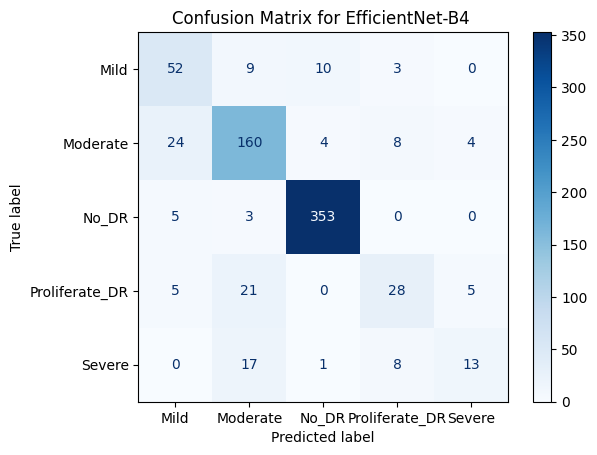

In [ ]:
#Confusion matrix for EfficientNet-B4

y_true = valid_data.classes

# Predict labels for the validation data
# Get the predicted probabilities for each class and take the class with the highest probability
y_pred_probs = model.predict(valid_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=valid_data.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for EfficientNet-B4 ")
plt.show()


In [ ]:
#Classification Report for EfficientNet-B4

# Generate the classification report
class_labels = list(valid_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)

# Print the detailed classification report
print("Classification Report:\n")
print(report)

Classification Report:

                precision    recall  f1-score   support

          Mild       0.74      0.46      0.57        74
      Moderate       0.69      0.89      0.78       200
         No_DR       0.97      0.98      0.97       361
Proliferate_DR       0.75      0.31      0.43        59
        Severe       0.41      0.49      0.45        39

      accuracy                           0.82       733
     macro avg       0.71      0.62      0.64       733
  weighted avg       0.83      0.82      0.81       733



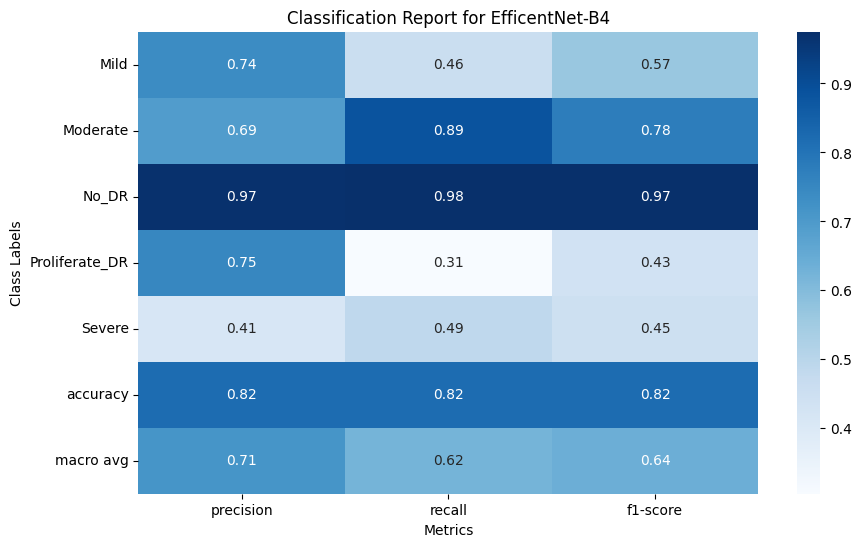

In [ ]:
# Display Classification report for EfficientNet-B4

# Extract class labels from the validation data generator
class_labels = list(valid_data.class_indices.keys())

# Generate the classification report as a dictionary
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert the report into a DataFrame for easy plotting
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report for EfficientNet-B4")
plt.xlabel("Metrics")
plt.ylabel("Class Labels")
plt.show()


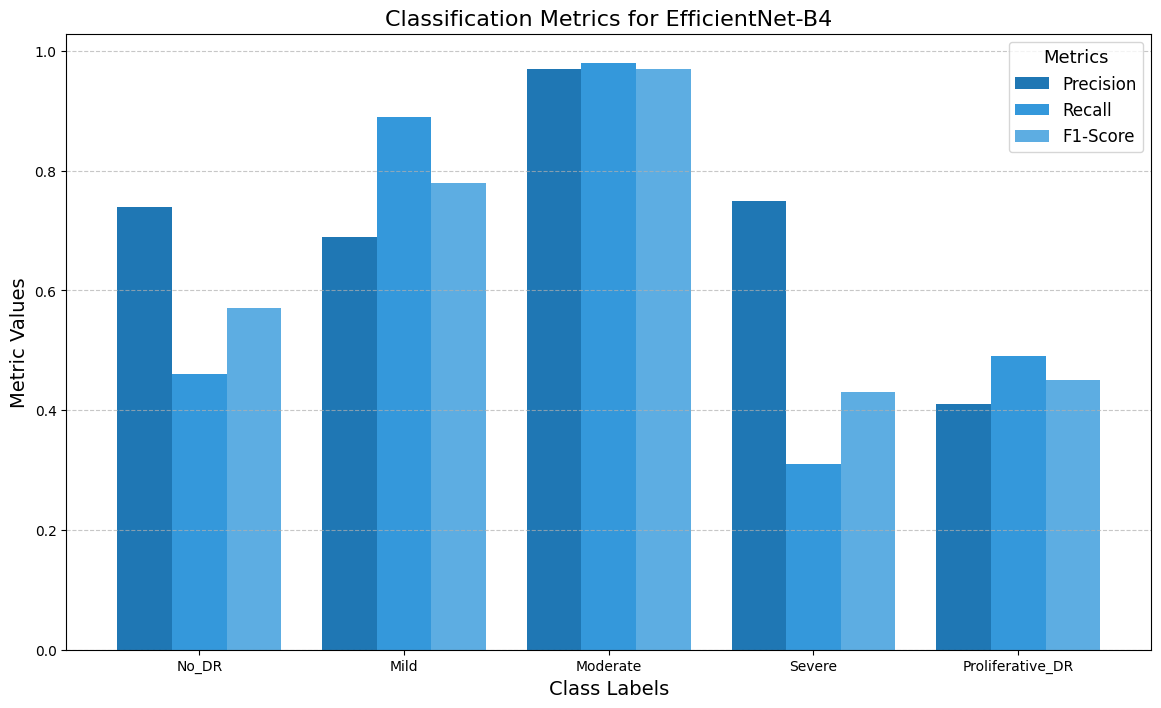

In [ ]:
#Plotting classification Matrix for EfficientNet-B4

data = {
   'Precision': [0.74, 0.69, 0.97, 0.75, 0.41],
    'Recall': [0.46, 0.89, 0.98, 0.31, 0.49],
    'F1-Score': [0.57, 0.78, 0.97, 0.43, 0.45]
}

# Class names for diabetic retinopathy stages
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']

# Create DataFrame
report_df = pd.DataFrame(data, index=class_names)

blue_theme_colors = ['#1f77b4', '#3498db', '#5dade2']
ax = report_df.plot(kind='bar', figsize=(14, 8), width=0.8, color=blue_theme_colors)
ax.set_title('Classification Matrics for EfficientNet-B4', fontsize=16)
ax.set_xlabel('Class Labels', fontsize=14)
ax.set_ylabel('Metric Values', fontsize=14)
ax.legend(title='Metrics', title_fontsize='13', fontsize='12')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Print Training Accuracy and Validation Accuracy for EfficientNet-B4

print(history.history.keys())

final_training_accuracy = history.history['acc'][-1] if 'acc' in history.history else history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_acc'][-1] if 'val_acc' in history.history else history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.4f}")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
Final Training Accuracy: 0.9071
Final Validation Accuracy: 0.8336


In [ ]:
# DenseNet-201 Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201

model = tf.keras.Sequential([
    DenseNet201(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history=model.fit(train_data,validation_data = valid_data,callbacks=[lr_callback],epochs=10,verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 776s 4s/step - accuracy: 0.6457 - loss: 1.1887 - val_accuracy: 0.6630 - val_loss: 1.0635 - learning_rate: 1.0000e-04
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 788ms/step - accuracy: 0.7874 - loss: 0.5914 - val_accuracy: 0.7190 - val_loss: 0.9103 - learning_rate: 1.0000e-04
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 787ms/step - accuracy: 0.8038 - loss: 0.5367 - val_accuracy: 0.7490 - val_loss: 0.6764 - learning_rate: 1.0000e-04
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 775ms/step - accuracy: 0.8336 - loss: 0.4200 - val_accuracy: 0.7763 - val_loss: 0.6391 - learning_rate: 1.0000e-04
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - accuracy: 0.8553 - loss: 0.3678 - val_accuracy: 0.7817 - val_loss: 0.6581 - learning_rate: 1.0000e-04
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 761ms/step - accuracy: 0.8766 - loss: 0.3199 - val_accuracy: 0.7708 - val_loss: 0.7509 - learning_rate: 1.0000e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 784ms/step - accuracy: 0.8857

23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step


<Figure size 1000x600 with 0 Axes>

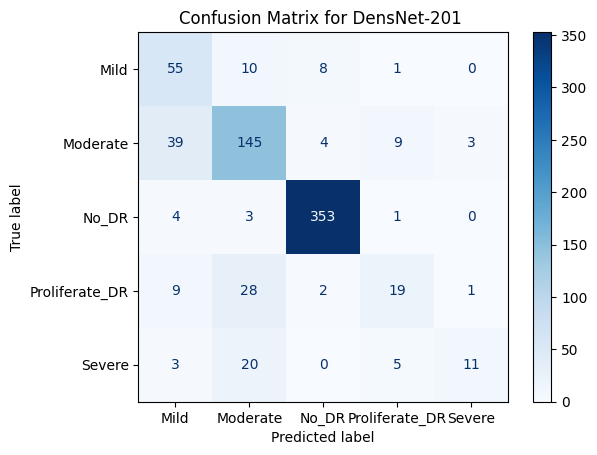

In [ ]:
#Confusion matrix for DenseNet-201

y_true = valid_data.classes

# Predict labels for the validation data
# Get the predicted probabilities for each class and take the class with the highest probability
y_pred_probs = model.predict(valid_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=valid_data.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for DensNet-201 ")
plt.show()


In [ ]:
#Classification Report for DenseNet-201

# Generate the classification report
class_labels = list(valid_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)

# Print the detailed classification report
print("Classification Report:\n")
print(report)

Classification Report:

                precision    recall  f1-score   support

          Mild       0.50      0.74      0.60        74
      Moderate       0.70      0.72      0.71       200
         No_DR       0.96      0.98      0.97       361
Proliferate_DR       0.54      0.32      0.40        59
        Severe       0.73      0.28      0.41        39

      accuracy                           0.80       733
     macro avg       0.69      0.61      0.62       733
  weighted avg       0.80      0.80      0.79       733



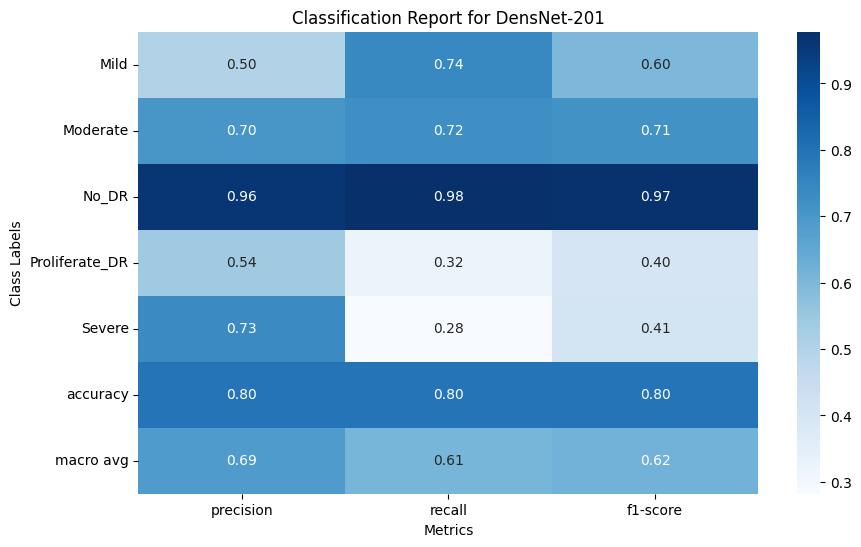

In [ ]:
# Display Classification report for DenseNet-201

# Extract class labels from the validation data generator
class_labels = list(valid_data.class_indices.keys())

# Generate the classification report as a dictionary
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert the report into a DataFrame for easy plotting
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report for DensNet-201")
plt.xlabel("Metrics")
plt.ylabel("Class Labels")
plt.show()

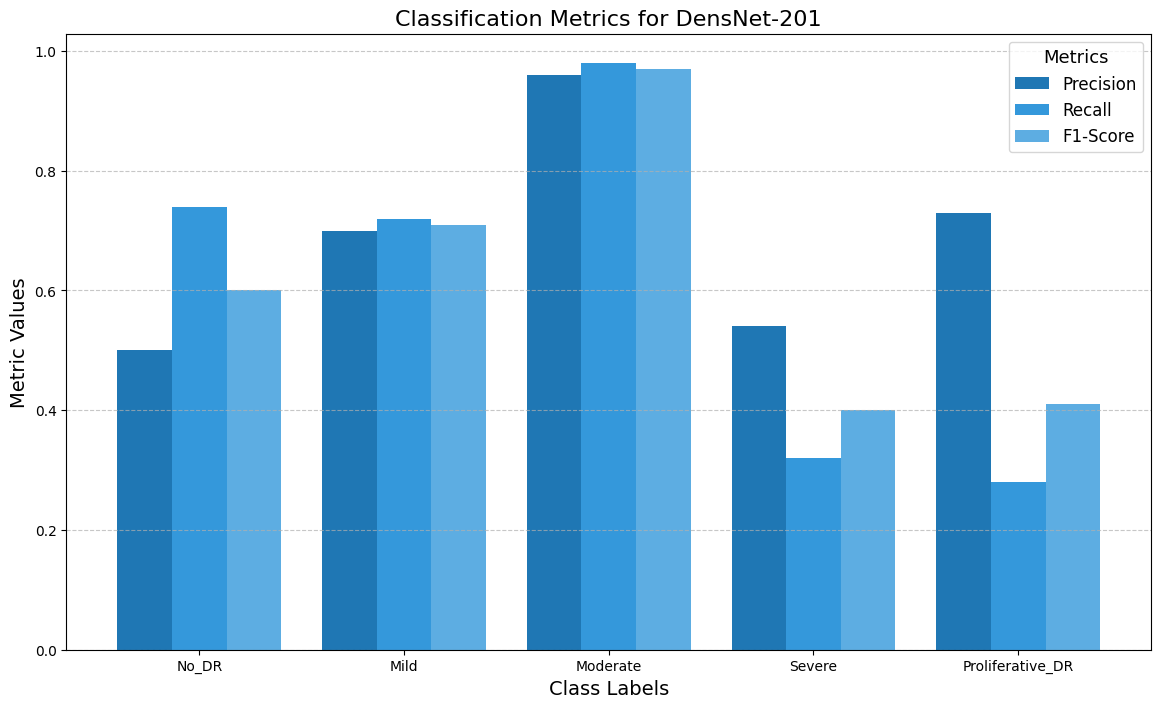

In [ ]:
#Plotting classification Matrix for DenseNet-201
data = {
    'Precision': [0.50, 0.70, 0.96, 0.54, 0.73],
    'Recall': [0.74, 0.72, 0.98, 0.32, 0.28],
    'F1-Score': [0.60, 0.71, 0.97, 0.40, 0.41]
}

# Class names for diabetic retinopathy stages
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']

# Create DataFrame
report_df = pd.DataFrame(data, index=class_names)

blue_theme_colors = ['#1f77b4', '#3498db', '#5dade2']  # Shades of blue
ax = report_df.plot(kind='bar', figsize=(14, 8), width=0.8, color=blue_theme_colors)
ax.set_title('Classification Metrics for DensNet-201', fontsize=16)
ax.set_xlabel('Class Labels', fontsize=14)
ax.set_ylabel('Metric Values', fontsize=14)
ax.legend(title='Metrics', title_fontsize='13', fontsize='12')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Print Training Accuracy and Validation Accuracy for DensNet-201
print(history.history.keys())

final_training_accuracy = history.history['acc'][-1] if 'acc' in history.history else history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_acc'][-1] if 'val_acc' in history.history else history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.4f}")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
Final Training Accuracy: 0.9211
Final Validation Accuracy: 0.8008


In [ ]:
# Xception Model

import tensorflow as tf
from tensorflow.keras.applications import Xception

model = tf.keras.Sequential([
        Xception(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history=model.fit(train_data,validation_data = valid_data,callbacks=[lr_callback],epochs=20,verbose=1)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 846ms/step - accuracy: 0.9338 - loss: 0.1885 - val_accuracy: 0.7749 - val_loss: 0.9946 - learning_rate: 1.0000e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 751ms/step - accuracy: 0.9567 - loss: 0.1282 - val_accuracy: 0.8022 - val_loss: 0.8513 - learning_rate: 1.0000e-04
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 737ms/step - accuracy: 0.9568 - loss: 0.1362 - val_accuracy: 0.7913 - val_loss: 1.0761 - learning_rate: 1.0000e-04
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 747ms/step - accuracy: 0.9490 - loss: 0.1486 - val_accuracy: 0.7613 - val_loss: 0.9409 - learning_rate: 1.0000e-04
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 750ms/step - accuracy: 0.9631 - loss: 0.1109 - val_accuracy: 0.8104 - val_loss: 1.1691 - learning_rate: 1.0000e-04
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 753ms/step - accuracy: 0.9697 - loss: 0.0900 - val_accuracy: 0.7858 - val_loss: 1.0861 - learning_rate: 1.0000e-04
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 745ms/step - acc

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 492ms/step


<Figure size 800x600 with 0 Axes>

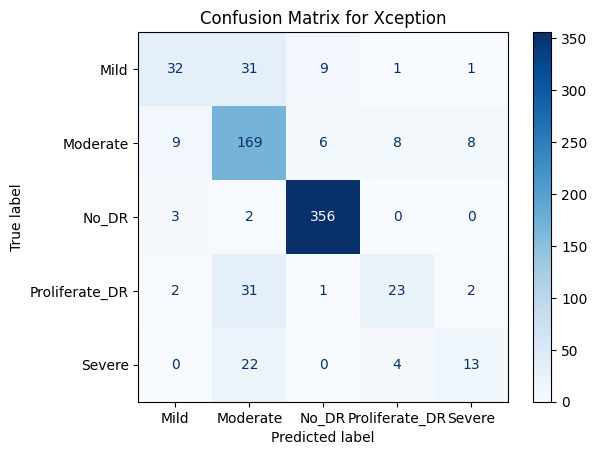

In [ ]:
#Confusion matrix for Xception
y_true = valid_data.classes

# Predict labels for the validation data
# Get the predicted probabilities for each class and take the class with the highest probability
y_pred_probs = model.predict(valid_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=valid_data.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Xception")
plt.show()

In [ ]:
#Classification Report for Xception

# Generate the classification report
class_labels = list(valid_data.class_indices.keys())  # Get class names from the generator
report = classification_report(y_true, y_pred, target_names=class_labels)

# Print the detailed classification report
print("Classification Report:\n")
print(report)

Classification Report:

                precision    recall  f1-score   support

          Mild       0.70      0.43      0.53        74
      Moderate       0.66      0.84      0.74       200
         No_DR       0.96      0.99      0.97       361
Proliferate_DR       0.64      0.39      0.48        59
        Severe       0.54      0.33      0.41        39

      accuracy                           0.81       733
     macro avg       0.70      0.60      0.63       733
  weighted avg       0.80      0.81      0.80       733



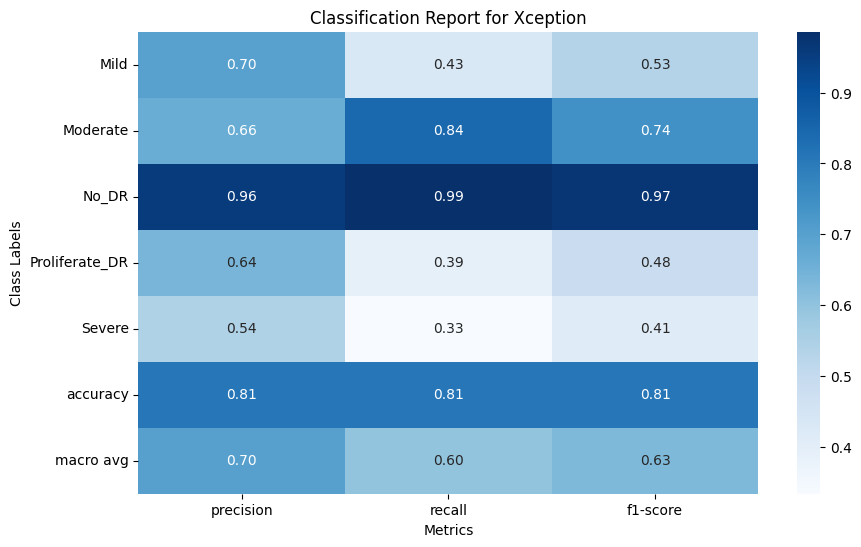

In [ ]:
# Display Classification report for Xception

# Extract class labels from the validation data generator
class_labels = list(valid_data.class_indices.keys())

# Generate the classification report as a dictionary
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert the report into a DataFrame for easy plotting
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report for Xception")
plt.xlabel("Metrics")
plt.ylabel("Class Labels")
plt.show()

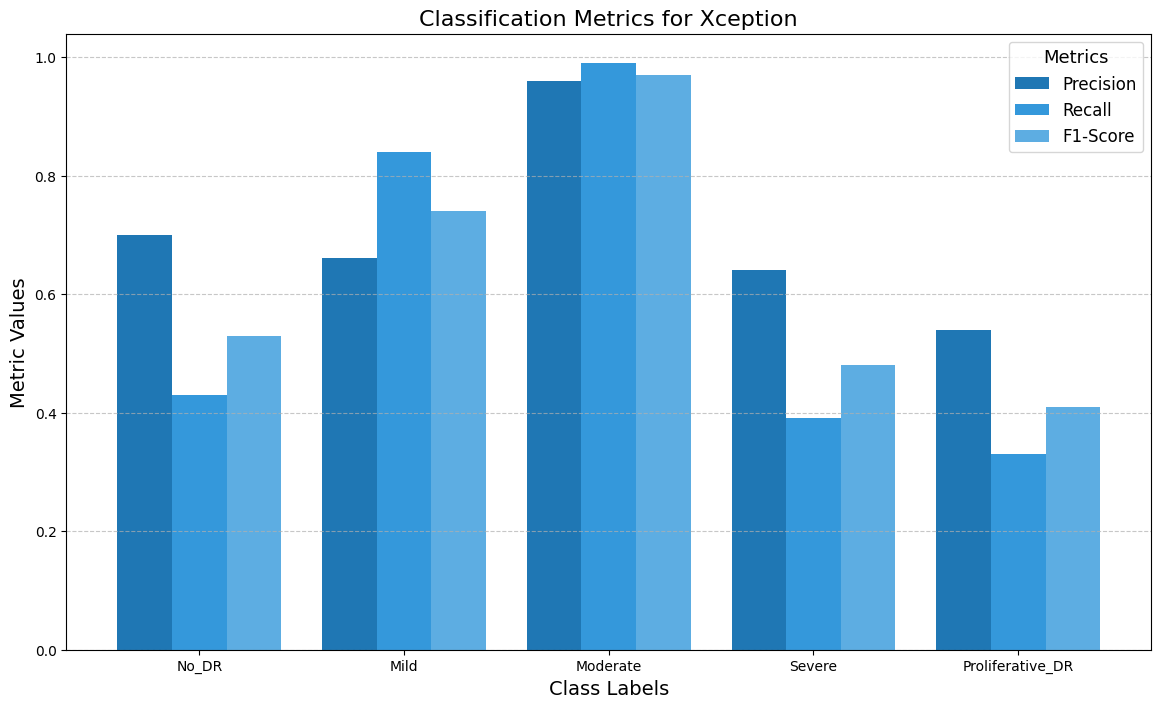

In [ ]:
#Plotting classification Matrix for Xception
data = {
    'Precision': [0.70, 0.66, 0.96, 0.64, 0.54],
    'Recall': [0.43, 0.84, 0.99, 0.39, 0.33],
    'F1-Score': [0.53, 0.74, 0.97, 0.48, 0.41]
}

# Class names for diabetic retinopathy stages
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']

# Create DataFrame
report_df = pd.DataFrame(data, index=class_names)

# Using a blue-themed color palette for the bars
blue_theme_colors = ['#1f77b4', '#3498db', '#5dade2']  # Shades of blue
ax = report_df.plot(kind='bar', figsize=(14, 8), width=0.8, color=blue_theme_colors)
ax.set_title('Classification Metrics for Xception', fontsize=16)
ax.set_xlabel('Class Labels', fontsize=14)
ax.set_ylabel('Metric Values', fontsize=14)
ax.legend(title='Metrics', title_fontsize='13', fontsize='12')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Print Training Accuracy and Validation Accuracy for Xception
print(history.history.keys())

final_training_accuracy = history.history['acc'][-1] if 'acc' in history.history else history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_acc'][-1] if 'val_acc' in history.history else history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.4f}")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
Final Training Accuracy: 0.9840
Final Validation Accuracy: 0.8076
